## 1. Import the packages

In [53]:
import os
import time
import random
import numpy as np
import pandas as pd
from IPython.display import clear_output 
from collections import defaultdict
import matplotlib.pyplot as plt

# 2. Set the GridWorld Environment

In [ ]:

class GridWorld:
  def __init__(self, width, height, state_mode="relative", relative_state_width=2, start=[0, 0], goal=None, start_method="left_top", goal_method="right_bottom", goal_included_in_state=True, dir_included_in_state=True):
    self.width = width
    self.height = height
    self.action_size = 5
    self.state_size = 2
    self.act_to_str = ["○","△","▽","◁","▷"]
    self.str_to_act = {"○":0, "△":1, "▽":2, "◁":3, "▷":4}
    self.state_mode = state_mode

    self.matrix = [["　" for j in range(self.width)] for i in range(self.height)]
    self.state = start
    self.pos = start

    self.goal = goal
    self.start = start
    self.start_method = start_method
    self.goal_method = goal_method

    self.obstacle_reward = -1
    self.goal_reward = 1
    self.alive_reward = -0.1
    self.unavailable_reward = -1
    self.DELAY = 1

    self.giis = goal_included_in_state
    self.diis = dir_included_in_state

    self.relative_state_width = relative_state_width

    self._obstacles = []
    self.obstacles = []

  def reset_obstacles(self):
    self.obstacles = [obs for obs in self._obstacles]

  def reset_start_goal(self):
    if self.start_method == "left_top":
      self.start = [0, 0]
      self.pos = self.start
    elif self.start_method == "random":
      check = False
      x = 0
      y = 0
      while not check:
        check = True
        x = random.randrange(0, self.width)
        y = random.randrange(0, self.height)
        for obs in self._obstacles:
          if x==obs[0] and y==obs[1]:
            check = False
        self.start = [x, y]
        self.pos = self.start
    else:
      raise Exception("Undefined Start Method")

    if self.goal_method == "right_bottom":
      self.goal = [self.width-1, self.height-1]
    elif self.goal_method == "random":
      check = False
      x = 0
      y = 0
      while not check:
        check = True
        x = random.randrange(0, self.width)
        y = random.randrange(0, self.height)
        for obs in self._obstacles:
          if (x==obs[0] and y==obs[1]) or (x==self.start[0] and y==self.start[1]):
            check = False
        self.goal = [x, y]
    else:
      raise Exception("Undefined Goal Method")

  def add_obstacles(self, posx, posy, dir=0, method="reflect", include_state=True): # 정지:O 상:^ 하:v 좌:< 우:> #method: "reflect", ["O","^","v","<",">"]
    self._obstacles.append([posx, posy, dir, method, include_state])
    self.reset_state()

  def refresh_matrix(self):
    self.matrix = [["　" for j in range(self.width)] for i in range(self.height)]
    for obs in self.obstacles:
      self.matrix[obs[1]][obs[0]] = self.act_to_str[obs[2]]

  def reset_state(self):
    self.reset_obstacles()
    self.reset_start_goal()
    self.refresh_matrix()

    if self.state_mode == "absolute":
      self.state = [self.pos[0], self.pos[1]]
    elif self.state_mode == "relative":
      self.state = [0 for _ in range((self.relative_state_width*2+1)**2)]

    if self.giis:
      self.state += [self.goal[0]-self.pos[0], self.goal[1]-self.pos[1]]

    if self.state_mode == "absolute":
      for obs in self.obstacles:
        if obs[4]:
          if self.diis:
            self.state += [obs[0]-self.state[0],obs[1]-self.state[1], obs[2]]
          else:
            self.state += [obs[0]-self.state[0],obs[1]-self.state[1]]
    elif self.state_mode == "relative": 
      for i in range((self.relative_state_width*2+1)**2):
        x = i % (self.relative_state_width*2 + 1)
        y = i // (self.relative_state_width*2 + 1)
        x += self.pos[0] - self.relative_state_width
        y += self.pos[1] - self.relative_state_width

        if x < 0 or y < 0 or x >=self.width or y>=self.height:
          self.state[i] = 9
        elif x==self.goal[0] and y==self.goal[1] and self.giis:
          self.state[i] = 8
        elif self.matrix[y][x] in self.act_to_str:
          self.state[i] = self.str_to_act[self.matrix[y][x]]

    self.state_size = len(self.state)

  def refresh_state(self):
    if self.state_mode == "absolute":
      self.state = [self.pos[0], self.pos[1]]
    elif self.state_mode == "relative":
      self.state = [6 for _ in range((self.relative_state_width*2+1)**2)]

    if self.giis:
      self.state += [self.goal[0]-self.pos[0], self.goal[1]-self.pos[1]]

    if self.state_mode == "absolute":
      for obs in self.obstacles:
        if obs[4]:
          if self.diis:
            self.state += [obs[0]-self.state[0],obs[1]-self.state[1], obs[2]]
          else:
            self.state += [obs[0]-self.state[0],obs[1]-self.state[1]]
    elif self.state_mode == "relative": 
      for i in range((self.relative_state_width*2+1)**2):
        x = i % (self.relative_state_width*2 + 1)
        y = i // (self.relative_state_width*2 + 1)
        x += self.pos[0] - self.relative_state_width
        y += self.pos[1] - self.relative_state_width

        if x < 0 or y < 0 or x >=self.width or y>=self.height:
          self.state[i] = 9
        elif x==self.goal[0] and y==self.goal[1] and self.giis:
          self.state[i] = 8
        elif self.matrix[y][x] in self.act_to_str:
          if not self.diis:
            self.state[i] = 7
          else:
            self.state[i] = self.str_to_act[self.matrix[y][x]]

  def reset(self):
    self.reset_state()
    return self.state

  def show(self, state, reward, action):
    clear_output()
    if self.state_mode=="absolute":
      print(f"state:{state}, reward:{reward}, action:{self.act_to_str[action]}")
    elif self.state_mode=="relative":
      print("state:")
      for i in range(self.relative_state_width*2+1):
        for j in range(self.relative_state_width*2+1):
          print(state[i*(self.relative_state_width*2+1)+j], end=" ")
        print()
      if self.giis:
        print(f"[{state[-2]}, {state[-1]}]")
      print(f"reward:{reward}, action:{self.act_to_str[action]}")

    print("┌"+"─"*(self.width)+"┐")

    for l in range(self.height):
      print("│", end="")
      for m in range(self.width):
        if self.pos[0] == m and self.pos[1] == l:
          print("□", end="")
        elif self.goal[0] == m and self.goal[1] == l:
          print("◆", end="")
        elif self.start[0] == m and self.start[1] == l:
          print("◇", end="")
        else:
          print(self.matrix[l][m], end="")
      print("│")

    print("└"+"─"*(self.width)+"┘")
    time.sleep(self.DELAY)

  def step(self, action, show=False):
    for obs in self.obstacles:
      
      if obs[2] == 0:
        pass
      elif obs[2] == 1 and ((not obs[1] == 0) and self.matrix[obs[1]-1][obs[0]]):
        obs[1] -= 1
      elif obs[2] == 2 and ((not obs[1] == self.height-1) and self.matrix[obs[1]+1][obs[0]]):
        obs[1] += 1
      elif obs[2] == 3 and ((not obs[0] == 0) and self.matrix[obs[1]][obs[0]-1]):
        obs[0] -= 1
      elif obs[2] == 4 and ((not obs[0] == self.width-1) and self.matrix[obs[1]][obs[0]+1]):
        obs[0] += 1
      else:
        pass

      
      if obs[3]=="reflect":
        if obs[2] == 0:
          pass
        elif obs[2] == 1 and obs[1] == 0:
          obs[2] = 2
        elif obs[2] == 2 and obs[1] == self.height-1:
          obs[2] = 1
        elif obs[2] == 3 and obs[0] == 0:
          obs[2] = 4
        elif obs[2] == 4 and obs[0] == self.width-1:
          obs[2] = 3
        else:
          pass
      elif obs[3]=="random":
        obs[2] = random.randrange(0, 5)
      
    self.refresh_matrix()


    # 에이전트 움직이기
    next_pos = [self.pos[0], self.pos[1]]
    reward = 0
    done = False

    if action == 0:
      next_pos = next_pos
    elif action == 1 and not self.pos[1]==0:
      next_pos[1] -= 1
    elif action == 2 and not self.pos[1]==self.height-1:
      next_pos[1] += 1
    elif action == 3 and not self.pos[0]==0:
      next_pos[0] -= 1
    elif action == 4 and not self.pos[0]==self.width-1:
      next_pos[0] += 1
    else:
      next_pos = next_pos
      reward += self.unavailable_reward

    #보상, 완료 여부

    if self.matrix[next_pos[1]][next_pos[0]] in self.act_to_str:
      reward += self.obstacle_reward
      done = False
    elif next_pos[0]==self.goal[0] and next_pos[1]==self.goal[1]:
      reward += self.goal_reward
      done = True
    else:
      pass
    reward += self.alive_reward

    self.pos = next_pos
    
    self.refresh_state()

    if show:
      env.show(self.state, reward, action)


    return self.state, reward, done

# 3. Declaration of Q-learning Agent 

In [15]:
class QLearning:
  def __init__(self, actions):
    self.ACTIONS = np.array(actions)
    self.step_size = 0.01
    self.discount_factor = 0.9
    self.epsilon = 0.1
    self.q_table = defaultdict(lambda:[0.0 for _ in range(len(actions))])

  def get_action(self, state):
    if np.random.rand() < self.epsilon:
        action = np.random.choice(self.ACTIONS)
    else:
        q_list = self.q_table[str(state)]
        action = self.ACTIONS[np.random.choice(np.argwhere(q_list == np.amax(q_list)).flatten().tolist())]
    return action

  def save(self, root):
    df = pd.DataFrame([[state, self.q_table[state]] for state in self.q_table.keys()], columns=['states', 'q_list'])
    df.to_csv(root)

  def load(self, root):
    def str_to_list(s):
      s = s.split('[')
      s = s[1].split(']')
      s = s[0].split(', ')
      for i in range(len(s)):
        s[i] = float(s[i])
      return s
    
    self.q_table = defaultdict(lambda:[0.0 for _ in range(len(self.Actions))])
    df = pd.read_csv(root)
    for idx in df.index:
      self.q_table[df['states'][idx]] = str_to_list(df['q_list'][idx])
      
  def learn(self, state, action, reward, next_state):
    
    state, next_state = str(state), str(next_state)
    
    current_q = self.q_table[state][np.argwhere(self.ACTIONS==action)[0][0]]
    next_state_q = max(self.q_table[next_state])

    td = reward + self.discount_factor * next_state_q - current_q
    new_q = current_q + self.step_size * td
    self.q_table[state][np.argwhere(self.ACTIONS==action)[0][0]] = new_q

# 4. Presentation of the GridWorld

In [45]:
env = GridWorld(7, 7,  state_mode="absolute", goal_included_in_state=False)
env.add_obstacles(1, 4, 0, include_state=False)
env.add_obstacles(2, 1, 0, include_state=False)
env.add_obstacles(2, 5, 0, include_state=False)
env.add_obstacles(5, 4, 0, include_state=False)
env.add_obstacles(6, 1, 0, include_state=False)

env.show([0, 0], 0, 0)

state:[0, 0], reward:0, action:○
┌───────┐
│□　　　　　　│
│　　○　　　○│
│　　　　　　　│
│　　　　　　　│
│　○　　　○　│
│　　○　　　　│
│　　　　　　◆│
└───────┘


# 5. Q-Learning Process in Epoch 5000

In [49]:
agent = QLearning([1, 2, 3, 4])

episodes = []
scores = []

for E in range(5000):
  state = env.reset()
  done = False

  score = 0

  while not done:
    action = agent.get_action(state)
    next_state, reward, done = env.step(action, show=False)
    next_action = agent.get_action(next_state)

    agent.learn(state, action, reward, next_state)

    score += reward

    state = next_state

  print(f"episode {E} - score {score}")

  scores.append(score)
  episodes.append(E)

episode 0 - score -24.700000000000045
episode 1 - score -33.300000000000104
episode 2 - score -6.899999999999988
episode 3 - score -16.799999999999983
episode 4 - score -12.199999999999982
episode 5 - score -14.699999999999974
episode 6 - score -25.000000000000092
episode 7 - score -3.400000000000001
episode 8 - score -4.099999999999997
episode 9 - score -37.40000000000021
episode 10 - score -12.599999999999971
episode 11 - score -22.90000000000002
episode 12 - score -26.800000000000107
episode 13 - score -9.299999999999983
episode 14 - score -13.699999999999974
episode 15 - score -19.700000000000014
episode 16 - score -5.799999999999995
episode 17 - score -21.300000000000036
episode 18 - score -5.899999999999995
episode 19 - score -8.099999999999985
episode 20 - score -16.799999999999997
episode 21 - score -4.799999999999995
episode 22 - score -15.199999999999973
episode 23 - score -16.499999999999982
episode 24 - score -17.099999999999994
episode 25 - score -8.89999999999998
episode 

# 6. The Scores about episodes

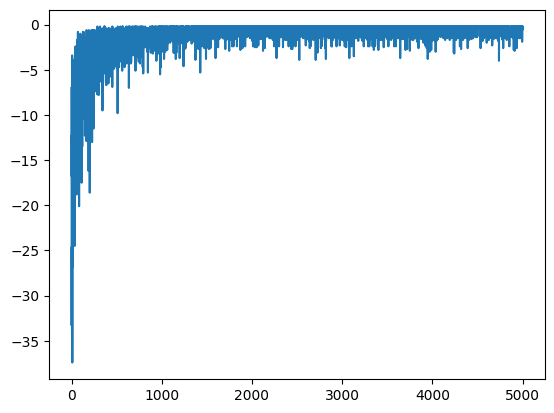

In [50]:
from matplotlib import pyplot as plt

plt.plot(episodes, scores)

# 7. Testing of the Q-Learning process

In [51]:
state = env.reset()
done = False

score = 0

while not done:
  action = agent.get_action(state)
  next_state, reward, done = env.step(action, show=True)
  next_action = agent.get_action(next_state)
  score += reward

  state = next_state

state:[6, 6], reward:0.9, action:▷
┌───────┐
│◇　　　　　　│
│　　○　　　○│
│　　　　　　　│
│　　　　　　　│
│　○　　　○　│
│　　○　　　　│
│　　　　　　□│
└───────┘
